In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob 
import matplotlib.image as img
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
import math
import csv
from PIL import Image
import time
import sklearn.metrics
import random
import onnx
import onnxruntime
import onnxscript
from onnxruntime import quantization
from torch.utils.mobile_optimizer import optimize_for_mobile
from torchvision.transforms import v2

In [23]:
# run parameters

version = 3
number_of_classes = 525
batch_size = 32

trainModel = True
quantizeModel = False
testModel = True
testOnnxModel = True

In [24]:
# set device 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device type:", device)
print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

# dtype = torch.float
torch.multiprocessing.set_sharing_strategy('file_system')

device type: cuda
current device: NVIDIA GeForce GTX 1060 6GB


In [25]:
# map labels to ids (alphabetically)

classIdByLabel = {}
classNames : list = sorted(os.listdir(os.path.join("..", "dane", "test")))
i = 0
for className in classNames:
    classIdByLabel[className] = i
    i += 1

# print("classIdByLabel:\n" + "\n".join([(str(classIdByLabel[c]) + "\t" + c) for c in classIdByLabel]))

# save ids and labels to file
# file = open("../dane/id_label.txt", "w")
# for label in classNames:
#     file.write(str(classIdByLabel[label]) + ";" + label +"\n")

In [26]:
# create a dataset class

class BirdDataset(Dataset):
    def __init__(self, dataset_type: str, classNames, transform):
        self.transform = transform
        self.image_paths = [path for sublist in [glob.glob(os.path.join("..", "dane", dataset_type, label, "*.jpg"), recursive=False) for label in classNames] for path in sublist] 
        self.labels = torch.tensor([classIdByLabel[path.split("/")[3]] for path in self.image_paths])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        image = Image.open(self.image_paths[i])
        # if self.transform:
        transformed_image = self.transform(image)
        image.close()
        return transformed_image, self.labels[i]


In [27]:
# create an early stopper

class EarlyStopper:
    def __init__(self, patience=1, min_change=0, mode='min'):
        self.patience = patience
        self.min_change = min_change
        self.mode = mode
        self.counter = 0
        self.min_variable = float('inf')
        self.max_variable = float('-inf')

    def stop_early(self, variable):
        if self.mode == 'min':
            if variable < self.min_variable:
                self.min_variable = variable
                self.counter = 0
            elif (variable - self.min_variable) > self.min_change:
                self.counter += 1
                if self.counter > self.patience:
                    return True
                
        elif self.mode == 'max':
            if variable > self.max_variable:
                self.max_variable = variable
                self.counter = 0
            elif (self.max_variable - variable) > self.min_change:
                self.counter += 1
                if self.counter > self.patience:
                    return True
                
        return False

dataset size: 63135


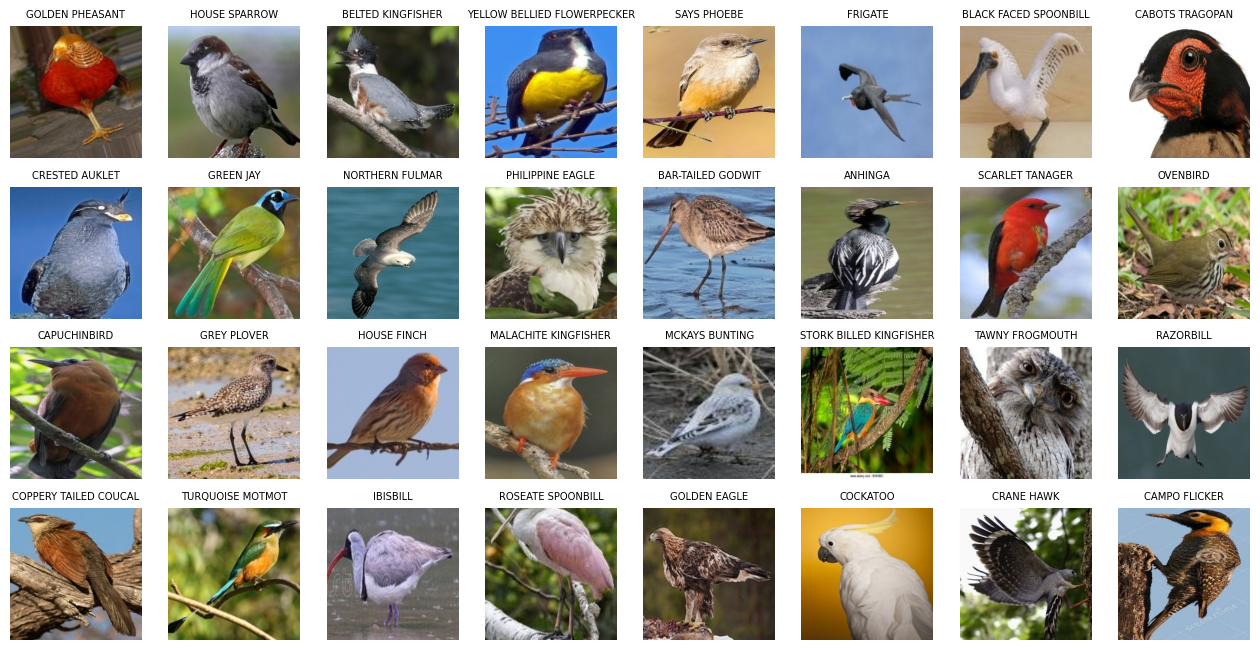

In [28]:
# show single batch of example data

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
example_batch_size = 32
example_number_of_classes = 525
exampleTrainDataset = BirdDataset("train", classNames[:example_number_of_classes], transform)

print("dataset size:", len(exampleTrainDataset))
# checkClasses = set([path.split("/")[3] for path in exampleTrainDataset.image_paths])
# print("all labels:", checkClasses)
# print("all image paths:\n", "\n".join(exampleTrainDataset.image_paths))

exampleTrainLoader = DataLoader(exampleTrainDataset, batch_size=example_batch_size, shuffle=True, num_workers=4, drop_last=True)

for i_batch, sample_batch in enumerate(exampleTrainLoader):
    images_batch, labels_batch = sample_batch
    # print(i_batch, images_batch[0].size(), len(labels_batch))

    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure(figsize=(16,8))
        plt.rc('font', size=6)

        for index in range(example_batch_size):
            plt.subplot(4,8,index+1)
            plt.imshow(images_batch[index].squeeze().permute(1,2,0))
            plt.title(list(classIdByLabel.keys())[list(classIdByLabel.values()).index(labels_batch[index])])
            plt.axis('off')

        
        plt.ioff()
        plt.show()
        break

In [29]:
# tune a pretrained model

weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = torchvision.models.efficientnet_b0(weights=weights)
# preprocess = weights.transforms()
preprocess = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
in_features = model.classifier[1].in_features
# print("in_features:", in_features)

dropout = 0.2
model.classifier = nn.Sequential(
    # nn.Dropout(dropout),
    nn.Linear(in_features, 900),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(900, 650),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(650, number_of_classes)
)

for name, param in model.named_parameters():
    if name.split(".")[0] == "classifier":
        param.requires_grad = True
    else: 
        param.requires_grad = False

# print(model)

In [30]:
# create datasets 

trainDataset = BirdDataset("train", classNames[:number_of_classes], preprocess)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

validDataset = BirdDataset("valid", classNames[:number_of_classes], preprocess)
validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

testDataset = BirdDataset("test", classNames[:number_of_classes], preprocess)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

In [31]:
# calculate class weights

classWeights = [0 for _ in range(525)]

# total = len(trainDataset.image_paths)

for className in classNames[:number_of_classes]:
    classWeights[classIdByLabel[className]] = 100.0 /len(os.listdir(os.path.join("..", "dane", "train", className)))
    # print(classWeights[classIdByLabel[className]], className)
print("min:", min(classWeights[:number_of_classes]), "max:", max(classWeights[:number_of_classes]))


min: 0.5208333333333334 max: 1.0204081632653061


In [32]:
# train

criterion = nn.CrossEntropyLoss(weight = torch.tensor(classWeights[:number_of_classes]).to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9) # , weight_decay=1e-5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold_mode='abs', verbose=True) 
early_stopper = EarlyStopper(patience=2, min_change=0,  mode='max')
batch_print_step = 500
epochs = 50
best_val_loss = float('inf')

# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model) # saving not supported
model.to(device)

if trainModel:
    for epoch in range(epochs):

        correct = 0
        running_loss = 0.0
        valid_running_loss = 0.0
        all_input_labels = []
        all_predicted_labels = []
        timestart = time.time()
        epochtime = time.time()

        # train
        model.train()
        for i, data in enumerate(trainLoader, 0):        
            # get the inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * images.size(0)
            
            if i % batch_print_step == batch_print_step-1:
                print("\r", f'[epoch: {epoch + 1}, {100*batch_size*(i + 1)/len(trainDataset):.3f}%, {math.floor(time.time() - timestart):3d}s] loss: {running_loss / len(trainDataset):.3f}', end="")
                timestart = time.time()

        # validate 
        model.eval()
        for i, data in enumerate(validLoader, 0):
            # get the inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

            # print statistics
            valid_running_loss += loss.item() * images.size(0)
            correct += torch.sum(predicted == labels.data)
            all_predicted_labels.append(predicted.cpu())
            all_input_labels.append(labels.cpu())
        
        epoch_loss = valid_running_loss / len(validDataset)
        accuracy = correct.double() / len(validDataset)
        all_input_labels = np.concatenate(all_input_labels)
        all_predicted_labels = np.concatenate(all_predicted_labels)
        f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='weighted', sample_weight=[classWeights[label_id] for label_id in all_input_labels])

        print("\r" + f'[epoch: {epoch + 1:2d}/{epochs}, time: {math.floor(time.time() - epochtime)}s] loss: {epoch_loss:.3f}, f1 score: {f1_score:.3f}, accuracy: {accuracy:.3f}')
            
        if early_stopper.stop_early(f1_score):
            print("stopping early")
            break

        scheduler.step(epoch_loss)

    print('done')

else:
    print("trainModel set to false")

[epoch:  1/50, time: 202s] loss: 5.696, f1 score: 0.050, accuracy: 0.070
[epoch:  2/50, time: 201s] loss: 2.606, f1 score: 0.399, accuracy: 0.422
[epoch:  3/50, time: 202s] loss: 1.668, f1 score: 0.602, accuracy: 0.606
[epoch:  4/50, time: 201s] loss: 1.347, f1 score: 0.663, accuracy: 0.664
[epoch:  5/50, time: 202s] loss: 1.229, f1 score: 0.696, accuracy: 0.693
[epoch:  6/50, time: 197s] loss: 1.103, f1 score: 0.723, accuracy: 0.721
[epoch:  7/50, time: 191s] loss: 1.010, f1 score: 0.743, accuracy: 0.742
[epoch:  8/50, time: 191s] loss: 0.967, f1 score: 0.755, accuracy: 0.752
[epoch:  9/50, time: 191s] loss: 0.962, f1 score: 0.758, accuracy: 0.757
[epoch: 10/50, time: 191s] loss: 0.893, f1 score: 0.770, accuracy: 0.769
[epoch: 11/50, time: 201s] loss: 0.865, f1 score: 0.778, accuracy: 0.777
[epoch: 12/50, time: 202s] loss: 0.849, f1 score: 0.783, accuracy: 0.782
[epoch: 13/50, time: 201s] loss: 0.839, f1 score: 0.783, accuracy: 0.780
[epoch: 14/50, time: 201s] loss: 0.839, f1 score: 0

In [33]:
# save/load the model
savepath = os.path.join("..", "saved_models", "model_" + str(number_of_classes) + "_ver" + str(version) + ".pt")

if trainModel:
    torch.save(model.state_dict(), savepath)
    print("saved: model_" + str(number_of_classes) + "_ver" + str(version) + ".pt")
else:
    model.load_state_dict(torch.load(savepath)) # try loading on cpu? map_location=torch.device('cpu')
    model.eval()
    print("loaded: model_" + str(number_of_classes) + "_ver" + str(version) + ".pt")

saved: model_525_ver3.pt


In [34]:
# split testDataset into test and quantization calibration sets

# split the test data to get a calibration set
class SplitBirdDataset(Dataset):
    def __init__(self, classNames, transform, paths_to_images):
        self.transform = transform
        self.image_paths = paths_to_images 
        self.labels = torch.tensor([classIdByLabel[path.split("/")[3]] for path in self.image_paths])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):

        image = Image.open(self.image_paths[i])

        # if self.transform:
        transformed_image = self.transform(image)
        
        image.close()
        return transformed_image, self.labels[i]

if quantizeModel:
    image_paths_smallerTest = []
    image_paths_calib = []

    for label in classNames:
        folder = os.path.join("..", "dane", "test", label)
        _, _, files = next(os.walk(folder))
        offset = math.floor(len(files)*2/3)
        image_paths_smallerTest.append([os.path.join(folder, file) for file in files[:offset]])
        image_paths_calib.append([os.path.join(folder, file) for file in files[offset:]])

    # flatten 
    image_paths_smallerTest = [item for sublist in image_paths_smallerTest for item in sublist]
    image_paths_calib = [item for sublist in image_paths_calib for item in sublist]

    calibDataset = SplitBirdDataset(classNames[:number_of_classes], preprocess, image_paths_calib)
    calibLoader = DataLoader(calibDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

    smallerTestDataset = SplitBirdDataset(classNames[:number_of_classes], preprocess, image_paths_smallerTest)
    smallerTestLoader = DataLoader(smallerTestDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

    # test
    print("calibration:", len(calibDataset))

    quantClassLengths = [0 for _ in range(number_of_classes)]
    for i, data in enumerate(calibLoader, 0):
        images, labels = data
        for label in labels:
            quantClassLengths[label] += 1

    print("\nnew test:", len(smallerTestDataset))

    newTestClassLengths = [0 for _ in range(number_of_classes)]
    for i, data in enumerate(smallerTestLoader, 0):
        images, labels = data
        for label in labels:
            newTestClassLengths[label] += 1

    print("classID\tquantLen\tnewTestLen")
    for i in range(number_of_classes):
        print("\t".join([str(i), str(quantClassLengths[i]), str(newTestClassLengths[i])]))
else:
    print("quantizeModel is set to false")

quantizeModel is set to false


In [35]:
# test the model

if (quantizeModel):
    used_test_loader = smallerTestLoader
    used_test_dataset = smallerTestDataset
else:
    used_test_loader = testLoader 
    used_test_dataset = testDataset 

if testModel:
    model.eval()

    test_running_loss = 0
    correct = 0
    all_predicted_labels = []
    all_input_labels = []

    for i, data in enumerate(used_test_loader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item() * images.size(0)
        correct += torch.sum(predicted == labels.data)
        all_predicted_labels.append(predicted.cpu())
        all_input_labels.append(labels.cpu())

    final_loss = test_running_loss / len(used_test_dataset)
    accuracy = correct.double() / len(used_test_dataset)
    all_input_labels = np.concatenate(all_input_labels)
    all_predicted_labels = np.concatenate(all_predicted_labels)
    f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='weighted', sample_weight=[classWeights[label_id] for label_id in all_input_labels])

    print("Test: ")
    print(f'loss: {final_loss:.3f}, f1 score: {f1_score:.3f}, accuracy: {accuracy:.3f}')
else:
    print("testModel set to false")

Test: 
loss: 0.753, f1 score: 0.815, accuracy: 0.812


In [36]:
# export model to onnx

# test single input
randomDatapoint = used_test_dataset[random.randint(0, len(used_test_dataset)-1)]
image, labelId = randomDatapoint
model_input = image.to(device).unsqueeze(0)
print("single random input:", classNames[labelId])

model_output = model(model_input)
_, predicted = torch.max(model_output, 1)
print("pytorch output:", classNames[predicted])


# export model to onnx
onnx_savepath = os.path.join("..", "saved_models", "model_" + str(number_of_classes) + "_ver" + str(version) + ".onnx")

torch.onnx.export(model, model_input, onnx_savepath)

# perform a check
onnx_model = onnx.load(onnx_savepath)
onnx.checker.check_model(onnx_model)

# allows to use the same dataLoader with onnx
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# test onnx model
onnxTestLoader = DataLoader(used_test_dataset, batch_size=1, shuffle=False, num_workers=4, drop_last=False)

ort_provider = ['CUDAExecutionProvider'] if (torch.cuda.is_available()) else ['CPUExecutionProvider']
# print("ort_provider:", ort_provider)
ort_sess = onnxruntime.InferenceSession(onnx_savepath, providers=ort_provider)

if testOnnxModel:
    correct = 0
    all_predicted_labels = []
    all_input_labels = []

    for i, data in enumerate(onnxTestLoader, 0):
        images, labels = data
        # images = images.to(device)
        # labels = labels.to(device)
        images = to_numpy(images)
        labels = to_numpy(labels)

        inputs = {ort_sess.get_inputs()[0].name: images}
        outputs = ort_sess.run(None, inputs)[0]
        predicted = np.argmax(outputs, axis=1)
        correct += np.sum(np.equal(predicted, labels))

        all_predicted_labels.append(predicted)
        all_input_labels.append(labels)
else:
    print("testOnnxModel is set to false")

single random input: AMETHYST WOODSTAR
pytorch output: AMETHYST WOODSTAR


In [37]:
# print onnx conversion test results

def show_onnx_model_results(correct, testingDataset, all_input_labels, all_predicted_labels):
    accuracy = float(correct.item()) / len(testingDataset)

    all_input_labels_temp = np.concatenate(all_input_labels)
    all_predicted_labels_temp = np.concatenate(all_predicted_labels)
    f1_score = sklearn.metrics.f1_score(all_input_labels_temp, all_predicted_labels_temp, average='weighted', sample_weight=[classWeights[label_id] for label_id in all_input_labels_temp])

    print("Test: ")
    print(f'f1 score: {f1_score:.3f}, accuracy: {accuracy:.3f}')

if testOnnxModel:
    show_onnx_model_results(correct, used_test_dataset, all_input_labels, all_predicted_labels)
else:
    print("testOnnxModel is set to false")

Test: 
f1 score: 0.815, accuracy: 0.812


In [38]:
# quantize onnx model

if quantizeModel:
    # preprocessing
    preprocessed_savepath = os.path.join("..", "saved_models", "model_" + str(number_of_classes) + "_ver" + str(version) + "_preprocessed.onnx")
    quantization.shape_inference.quant_pre_process(onnx_savepath, preprocessed_savepath, skip_symbolic_shape=False)

    preprocessed_model = onnx.load(preprocessed_savepath)
    onnx.checker.check_model(preprocessed_model)

    # calibration data reader (dataset should be separate from validation set but i don't have the energy for this - hope it will work anyway)
    class QuntizationDataReader(quantization.CalibrationDataReader):
        def __init__(self, dataloader, input_name):

            self.torch_dl = dataloader

            self.input_name = input_name
            self.datasize = len(self.torch_dl)

            self.enum_data = iter(self.torch_dl)

        def to_numpy(self, pt_tensor):
            return pt_tensor.detach().cpu().numpy() if pt_tensor.requires_grad else pt_tensor.cpu().numpy()

        def get_next(self):
            batch = next(self.enum_data, None)
            if batch is not None:
                return {self.input_name: self.to_numpy(batch[0])}
            else:
                return None

        def rewind(self):
            self.enum_data = iter(self.torch_dl)

    onnxCalibLoader = DataLoader(calibDataset, batch_size=1, shuffle=False, num_workers=4, drop_last=False) # validDataset
    qdr = QuntizationDataReader(onnxCalibLoader, input_name=ort_sess.get_inputs()[0].name)

    # static quantization
    q_static_opts = {"ActivationSymmetric":False, "WeightSymmetric":True}
    if torch.cuda.is_available():
        q_static_opts = {"ActivationSymmetric":True, "WeightSymmetric":True}

    quantized_savepath = os.path.join("..", "saved_models", "model_" + str(number_of_classes) + "_ver" + str(version) + "_quantized.onnx")
    quantized_model = quantization.quantize_static(model_input=preprocessed_savepath,
                                                model_output=quantized_savepath,
                                                calibration_data_reader=qdr,
                                                extra_options=q_static_opts)

In [39]:
# test the compressed model 

if quantizeModel:
    quantized_model = onnx.load(quantized_savepath)
    onnx.checker.check_model(quantized_model)
    ort_sess_quantized = onnxruntime.InferenceSession(quantized_savepath, providers=ort_provider)

    correct = 0
    all_predicted_labels = []
    all_input_labels = []

    for i, data in enumerate(onnxTestLoader, 0):
        images, labels = data
        # images = images.to(device)
        # labels = labels.to(device)
        images = to_numpy(images)
        labels = to_numpy(labels)

        inputs = {ort_sess_quantized.get_inputs()[0].name: images}
        outputs = ort_sess_quantized.run(None, inputs)[0]
        predicted = np.argmax(outputs, axis=1)
        correct += np.sum(np.equal(predicted, labels))

        all_predicted_labels.append(predicted)
        all_input_labels.append(labels)

    show_onnx_model_results(correct, smallerTestDataset, all_input_labels, all_predicted_labels)


In [40]:
# show file sizes

print(f'pytorch model size: {os.path.getsize(savepath)/(1024*1024):.2f} MB')
print(f'onnx model size: {os.path.getsize(onnx_savepath)/(1024*1024):.2f} MB')

if quantizeModel:
    print(f'compressed onnx model size: {os.path.getsize(quantized_savepath)/(1024*1024):.2f} MB')

pytorch model size: 23.51 MB
onnx model size: 23.21 MB


In [41]:
# convert model to ptl
ptl_savepath = os.path.join("..", "saved_models", "model_" + str(number_of_classes) + "_ver" + str(version) + "_lite.ptl")

traced_script_module = torch.jit.trace(model, model_input)
mobile_optimized_model = optimize_for_mobile(traced_script_module)
mobile_optimized_model._save_for_lite_interpreter(ptl_savepath)

print(f"mobile optimized model exported to {ptl_savepath}")

mobile optimized model exported to ../saved_models/model_525_ver3_lite.ptl


In [42]:
# test ptl model